In [73]:
import os
import sys
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

sys.path.append(os.getcwd() + "/")

from experiments import setup_experiments

exps = setup_experiments("exp205")

mode = "add"

In [74]:
csv = Path(exps.path) / "test.csv"
df = pd.read_csv(csv, low_memory=True)
df["bias_effect"] = [float(i.split("_")[-2]) for i in df["filename"]]
df["disease_effect"] = [float(i.split("_")[3]) for i in df["filename"]]
df["subject_effect"] = [float(i.split("_")[1]) for i in df["filename"]]
df["isv_dst_abs"] = np.abs(df["isv_dst"])

In [ ]:
def load_data(df, mode, cgm="hvae"):
    if mode == "add":
        img_dir = Path(exps.path) / "test" / "no_bias"
        gt_cf_dir = Path(exps.path) / "test" / "bias"
        cgm_cf_dir = Path(exps.path) / f"{cgm}_cfs" / "bias"

        cgm_pred_csv = Path(exps.path) / f"{cgm}_cfs" / "bias" / "predictions.csv"
        cgm_pred_df = pd.read_csv(cgm_pred_csv, low_memory=True)
        cgm_pred_dict = dict(zip(cgm_pred_df["filename"], cgm_pred_df["predictions"]))
        df[f"{cgm}_SFCN"] = df["filename"].map(cgm_pred_dict)

    elif mode == "remove":
        img_dir = Path(exps.path) / "test" / "bias"
        gt_cf_dir = Path(exps.path) / "test" / "no_bias"
        cgm_cf_dir = Path(exps.path) / f"{cgm}_cfs" / "no_bias"

        cgm_pred_csv = Path(exps.path) / f"{cgm}_cfs" / "no_bias" / "predictions.csv"
        cgm_pred_df = pd.read_csv(cgm_pred_csv, low_memory=True)
        cgm_pred_dict = dict(zip(cgm_pred_df["filename"], cgm_pred_df["predictions"]))
        df[f"{cgm}_SFCN"] = df["filename"].map(cgm_pred_dict)

    return df, img_dir, gt_cf_dir, cgm_cf_dir

In [38]:
from tifffile import tifffile as tiff


def three_images(df, idx, img_dir, gt_cf_dir, cgm_cf_dir):
    x = tiff.imread(os.path.join(img_dir, df.iloc[idx]["filename"])).squeeze()
    x_bar = tiff.imread(os.path.join(gt_cf_dir, df.iloc[idx]["filename"])).squeeze()
    x_tilde = tiff.imread(os.path.join(cgm_cf_dir, df.iloc[idx]["filename"])).squeeze()
    return x, x_bar, x_tilde

In [52]:
import numpy as np


def view_images(x, x_bar, x_tilde):
    from skimage import feature

    fig, axs = plt.subplots(1, 3, figsize=(10, 6))
    [ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]) for ax in axs]

    axs[0].imshow(x_bar - x, cmap="seismic", clim=(-1, 1))
    axs[0].set_title("GT difference")

    axs[1].imshow(x_tilde - x, cmap="seismic", clim=(-1, 1))
    axs[1].set_title("CGM cf difference")

    axs[2].imshow(x_bar - x_tilde, cmap="seismic", clim=(-1, 1))
    mse = np.mean((x_bar - x_tilde) ** 2)
    axs[2].set_title("Failure modes (mse=%.2E)" % mse)

    edges = feature.canny(x, sigma=1)

    for ax in axs.flatten():
        ax.imshow(edges, cmap="binary", alpha=0.25)

    return fig

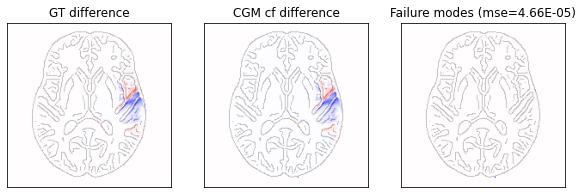

In [53]:
idx = 25
cgm = "hvae"

df, img_dir, gt_cf_dir, cgm_cf_dir = load_data(df, mode, cgm=cgm)
x, x_bar, x_tilde = three_images(df, idx, img_dir, gt_cf_dir, cgm_cf_dir)
view_images(x, x_bar, x_tilde).savefig(
    f"results/{cgm}-diff-{mode}.pdf", bbox_inches="tight"
)

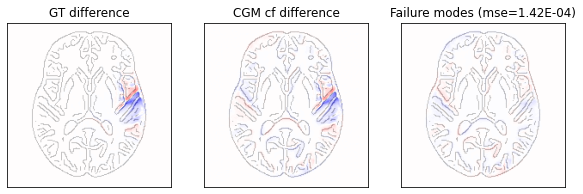

In [54]:
idx = 25
cgm = "macaw"

df, img_dir, gt_cf_dir, cgm_cf_dir = load_data(df, mode, cgm=cgm)
x, x_bar, x_tilde = three_images(df, idx, img_dir, gt_cf_dir, cgm_cf_dir)
view_images(x, x_bar, x_tilde).savefig(
    f"results/{cgm}-diff-{mode}.pdf", bbox_inches="tight"
)

In [88]:
def TEA(x_bar, x, x_tilde):
    z_bar = (x_bar - x).flatten()
    z_tilde = (x_tilde - x).flatten()

    z_bar_mag = np.linalg.norm(z_bar)
    z_tilde_mag = np.linalg.norm(z_tilde)
    projection = z_bar.dot(z_tilde) / z_bar_mag

    effectiveness = projection / z_bar_mag
    amplification = np.sqrt(z_tilde_mag**2 - projection**2)

    return effectiveness, amplification


def mse(x_bar, x_tilde):
    return np.mean((x_bar - x_tilde) ** 2)

In [ ]:
def metrics(df, mode, cgm):
    m = []
    e = []
    a = []
    df, img_dir, gt_cf_dir, cgm_cf_dir = load_data(df, mode, cgm=cgm)
    for i in range(len(df)):
        x, x_bar, x_tilde = three_images(df, i, img_dir, gt_cf_dir, cgm_cf_dir)
        m.append(mse(x_bar, x_tilde))
        eff, amp = TEA(x_bar, x, x_tilde)
        e.append(eff)
        a.append(amp)
    return df, mse, e, a


df, mse_macaw, e_macaw, a_macaw = metrics(df, mode, "macaw")
df, mse_hvae, e_hvae, a_hvae = metrics(df, mode, "hvae")


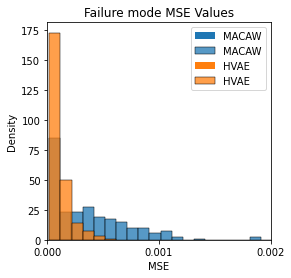

In [83]:
import seaborn as sns

plt.figure(figsize=(4, 4))
sns.histplot(mse_macaw, binwidth=0.0001, label="MACAW")
sns.histplot(mse_hvae, binwidth=0.0001, label="HVAE")
plt.legend()
plt.title("Failure mode MSE Values")
plt.xlabel("MSE")
plt.ylabel("Density")
plt.xlim(0, 0.002)
plt.xticks([0, 0.001, 0.002])
plt.savefig(f"results/mse-{mode}.pdf", bbox_inches="tight")

In [29]:
import seaborn as sns
import matplotlib.colors as mcolors


def scatter_plot(x, y, hue, data, title, cmap_s, cbar_txt):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    # Define intervals (bins) and corresponding colors
    boundaries = np.arange(0, 1.1, 0.2)  # Bins: [0, 0.1, 0.2, ..., 1.0]
    colors = sns.color_palette(cmap_s, len(boundaries) - 1)  # Generate N-1 colors

    # Create colormap and normalization
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(boundaries, cmap.N)

    scatter = sns.scatterplot(
        data=data, x=x, y=y, hue=hue, palette=cmap.reversed(), legend=False
    )

    ax.set(
        title=title,
        xlabel="Effectiveness",
        ylabel="Amplification",
        ylim=(0, 10),
        xlim=(0.5, 1.2),
    )
    # Add custom colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=boundaries)
    cbar.set_label(cbar_txt)

    fig.savefig(f"results/{title}-{cbar_txt}.pdf")

<ipython-input-29-500d4904122b>:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=boundaries)
<ipython-input-29-500d4904122b>:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=boundaries)
<ipython-input-29-500d4904122b>:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, 

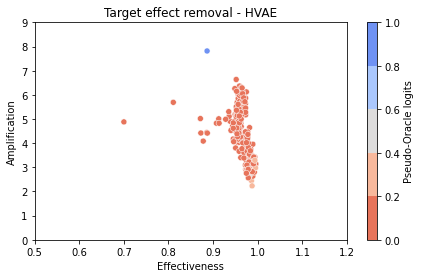

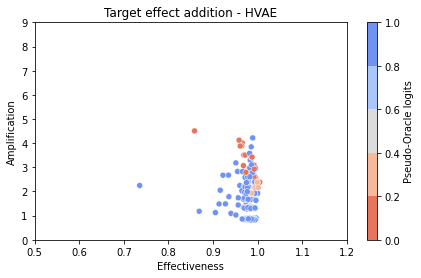

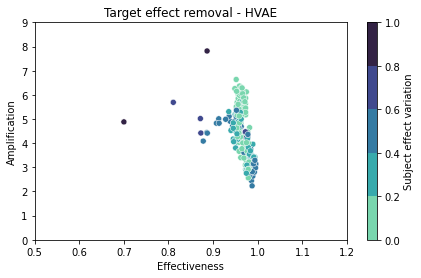

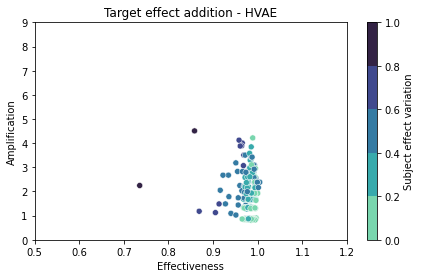

In [30]:
scatter_plot(
    x="hvae_e_remove",
    y="hvae_a_remove",
    hue="hvae_SFCN_no_bias",
    data=df,
    title="Target effect removal - HVAE",
    cmap_s="coolwarm",
    cbar_txt="Pseudo-Oracle logits",
)

scatter_plot(
    x="hvae_e_add",
    y="hvae_a_add",
    hue="hvae_SFCN_bias",
    data=df,
    title="Target effect addition - HVAE",
    cmap_s="coolwarm",
    cbar_txt="Pseudo-Oracle logits",
)

scatter_plot(
    x="hvae_e_remove",
    y="hvae_a_remove",
    hue="isv_dst_abs",
    data=df,
    title="Target effect removal - HVAE",
    cmap_s="mako",
    cbar_txt="Subject effect variation",
)


scatter_plot(
    x="hvae_e_add",
    y="hvae_a_add",
    hue="isv_dst_abs",
    data=df,
    title="Target effect addition - HVAE",
    cmap_s="mako",
    cbar_txt="Subject effect variation",
)